# Imports and Pre-requisites

In [1]:
import ee
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
%matplotlib inline

from datetime import timedelta, datetime


In [2]:
ee.Authenticate()

True

In [3]:
ee.Initialize(project="rwanda-climate-alerts")

# Collect Datasets

In [4]:
# Create map
Map = geemap.Map()

# Fetch the district outline of Rwanda
districts = ee.FeatureCollection("FAO/GAUL/2015/level2") \
                .filter(ee.Filter.eq("ADM0_NAME", "Rwanda"))

districts_geometry = districts.map(lambda feature: feature.geometry())

# Polygon englobing Rwanda
rwanda = ee.Geometry.Polygon([
    [
        [28.70, -2.85],
        [31.00, -2.85],
        [31.00, -1.00],
        [28.70, -1.00]
    ]
])

# Add a buffer around Rwanda
rwanda_buffered = rwanda.buffer(10000) # 10,000 meters
Map.centerObject(districts, 7)

In [5]:
# CHIRPS Daily Rainfall (mm/day)
chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')\
            .filterDate("2005-01-01", "2025-07-31")\
            .filterBounds(rwanda_buffered) \
            .map(lambda img: img.clip(rwanda_buffered))

# ERA5 Land Monthly Temperature
era5_temp = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY_AGGR") \
                .select("temperature_2m") \
                .filterDate("2005-01-01", "2025-07-31") \
                .filterBounds(rwanda_buffered) \
                .map(lambda img: img.clip(rwanda_buffered))

# Soil Moisture (ERA5 Land)
soil_moist = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY_AGGR") \
                .select("volumetric_soil_water_layer_1") \
                .filterDate("2005-01-01", "2025-07-31") \
                .filterBounds(rwanda_buffered) \
                .map(lambda img: img.clip(rwanda_buffered))

# MODIS NDVI (monthly, 250 m)
ndvi = ee.ImageCollection("MODIS/006/MOD13A1") \
            .select("NDVI") \
            .filterDate("2005-01-01", "2025-07-31") \
            .filterBounds(rwanda_buffered) \
            .map(lambda img: img.clip(rwanda_buffered))

# DEM (SRTM ~30m resolution)
dem = ee.Image("USGS/SRTMGL1_003").clip(rwanda_buffered)

# Calculate slope (degrees)
slope = ee.Terrain.slope(dem)

# ESA WorldCover 2020 (10 m)
# landcover = ee.Image("ESA/WorldCover/v200/2022").clip(rwanda_buffered)

# MODIS Land Cover (optional, for time series)
# modis_lc = ee.ImageCollection("MODIS/006/MCD12Q1") \
#                 .select("LC_Type1") \
#                 .filterDate("2001-01-01", "2020-12-31") \
#                 .filterBounds(districts) \
#                 .map(lambda img: img.clip(rwanda_buffered))

# Fetch Time series

In [11]:
def get_time_series(image_collection, district_name, start_date, end_date, scale):
    district = ee.FeatureCollection("FAO/GAUL/2015/level2") \
                    .filter(ee.Filter.eq("ADM0_NAME", "Rwanda")) \
                    .filter(ee.Filter.eq("ADM2_NAME", district_name)) \
                    .geometry()

    district_time_series = image_collection \
                            .filterDate(start_date, end_date) \
                            .getRegion(district, scale=scale) \
                            .getInfo()
    return district_time_series

bugesera_time_series = get_time_series(chirps, "Bugesera", "2024-01-01", "2024-12-31", 1000)

## Convert to pandas DataFrame

In [12]:
def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

bugesera_df = ee_array_to_df(bugesera_time_series, ['precipitation'])

## Plot the temperature

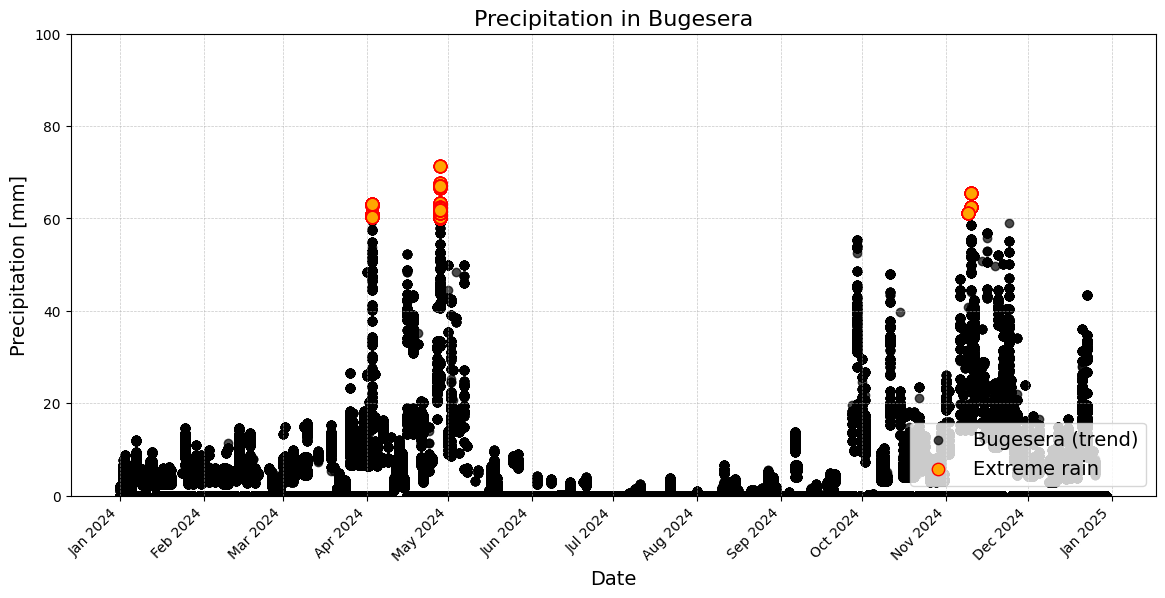

In [15]:
def chirps_plot():
    fig, ax = plt.subplots(figsize=(14, 6))

    ax.scatter(bugesera_df['datetime'], bugesera_df['precipitation'],
               color='black', linewidth=1, alpha=0.7, label='Bugesera (trend)')
               # c='black', alpha=0.2, label='Bugesera (data)')


    import matplotlib.dates as mdates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # e.g., "Jun 2025"
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    # bugesera_df['rolling'] = bugesera_df['precipitation'].rolling(window=7).mean()
    # ax.plot(bugesera_df['datetime'], bugesera_df['rolling'],
    #         color='red', linewidth=2, label='7-day average')

    extreme = bugesera_df[bugesera_df['precipitation'] > 60]
    ax.scatter(extreme['datetime'], extreme['precipitation'],
               color='orange', edgecolor='red', s=80, zorder=3, label='Extreme rain')


    ax.set_title('Precipitation in Bugesera', fontsize=16)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Precipitation [mm]', fontsize=14)
    ax.set_ylim(-0, 100)
    ax.grid(lw=0.5, ls='--', alpha=0.7)
    ax.legend(fontsize=14, loc='lower right')

chirps_plot()
plt.show()

In [43]:
def t_kelvin_to_celsius(t_kelvin):
    """Converts MODIS LST units to degrees Celsius."""
    t_celsius =  t_kelvin - 273.15
    return t_celsius

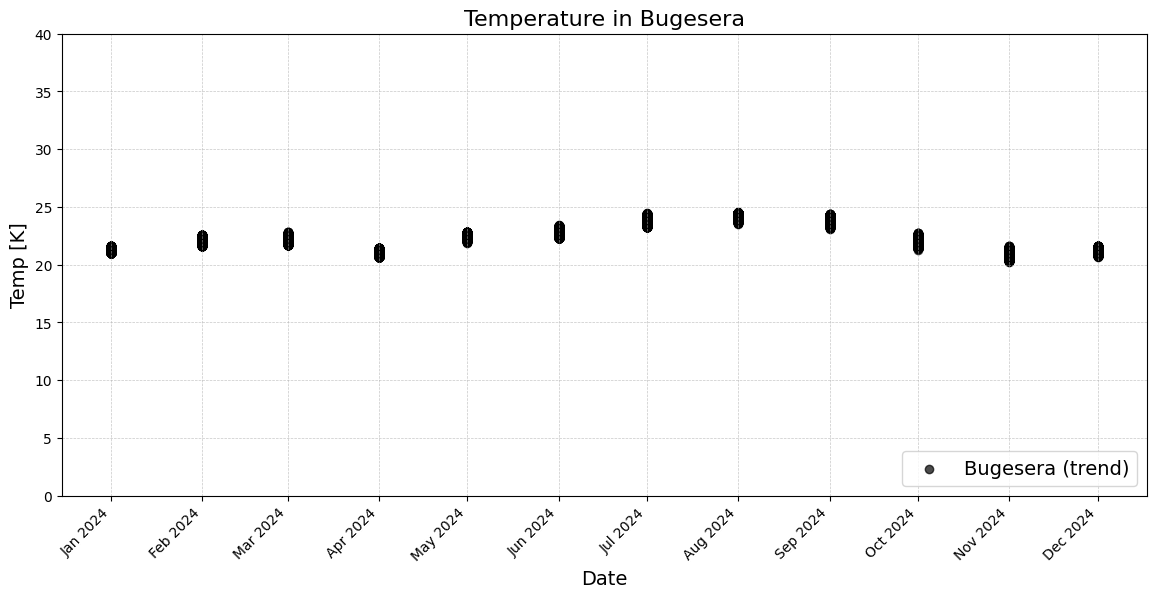

In [44]:
def era5_plot():
    fig, ax = plt.subplots(figsize=(14, 6))

    ax.scatter(era_5_bugesera_df['datetime'], era_5_bugesera_df['temperature_2m'],
               color='black', linewidth=1, alpha=0.7, label='Bugesera (trend)')
               # c='black', alpha=0.2, label='Bugesera (data)')

    import matplotlib.dates as mdates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # e.g., "Jun 2025"
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    # extreme = era_5_bugesera_df[era_5_bugesera_df['precipitation'] > 60]
    # ax.scatter(extreme['datetime'], extreme['precipitation'],
    #            color='orange', edgecolor='red', s=80, zorder=3, label='Extreme rain')

    ax.set_title('Temperature in Bugesera', fontsize=16)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Temp [K]', fontsize=14)
    ax.set_ylim(-0, 40)
    ax.grid(lw=0.5, ls='--', alpha=0.7)
    ax.legend(fontsize=14, loc='lower right')

era5_temp_time_series = get_time_series(era5_temp, "Bugesera", "2024-01-01", "2024-12-31", 1000)
era_5_bugesera_df = ee_array_to_df(era5_temp_time_series, ['temperature_2m'])
era_5_bugesera_df['temperature_2m'] = era_5_bugesera_df['temperature_2m'] \
                                        .apply(t_kelvin_to_celsius)

# print(era_5_bugesera_df[:5])

era5_plot()
plt.show()

## Mock plot function

In [ ]:
import matplotlib.dates as mdates

def plot_dataset(dataframe, title, label, xlabel, ylabel):
    fig, ax_1 = plt.subplots(figsize=(14, 6))

    ax_1.scatter(dataframe['datetime'], dataframe['temperature_2m'],
               color='black', linewidth=1, alpha=0.7, label=label)
               # c='black', alpha=0.2, label='Bugesera (data)')

    ax_1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # e.g., "Jun 2025"
    ax_1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.setp(ax_1.get_xticklabels(), rotation=45, ha="right")

    # extreme = dataframe[dataframe['precipitation'] > 60]
    # ax_1.scatter(extreme['datetime'], extreme['precipitation'],
    #            color='orange', edgecolor='red', s=80, zorder=3, label='Extreme rain')

    ax_1.set_title(title, fontsize=16)
    ax_1.set_xlabel(xlabel, fontsize=14)
    ax_1.set_ylabel(ylabel, fontsize=14)
    ax_1.set_ylim(-100, 100)
    ax_1.grid(lw=0.5, ls='--', alpha=0.7)
    ax_1.legend(fontsize=14, loc='lower right')


# Final map